The problem statement:
https://gym.openai.com/envs/MsPacman-v0

In [1]:
%load_ext autoreload
%autoreload 2

import gym
import random
import torch
from torchvision import transforms

import numpy as np
from collections import deque

import matplotlib.pyplot as plt
%matplotlib inline

from DDQN_agent_Atari_3D_PReplay_Tree import Agent
from myWrappers import StackEnv

!python -m pip install pyvirtualdisplay
from pyvirtualdisplay import Display
display = Display(visible=0, size=(1400, 900))
display.start()

is_ipython = 'inline' in plt.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

You are using pip version 9.0.1, however version 18.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
# Original Gym Env basic info
env = gym.make('MsPacman-v0')
env.seed(0)
state_space = env.observation_space.shape
action_space = env.action_space.n
input_shape = (84,84)
states_stack_depth = 4
print('State shape: ', state_space)
print('Number of actions: ', action_space)

State shape:  (210, 160, 3)
Number of actions:  9


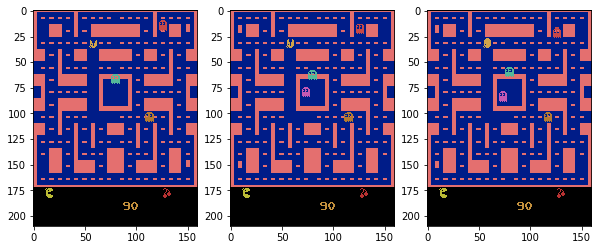

In [3]:
#import images
s = env.reset()
s0, s1, s2 = None, None, None

sampleframe = 240

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(10,6)) 
for i in range(1000):
    s, r, d, _ = env.step(1)
    if i == sampleframe:
        s0 = s
    if i == (sampleframe+1):
        s1= s
    if i == (sampleframe+2):
        s2= s
ax1.imshow(s0)
ax2.imshow(s1)
ax3.imshow(s2)

In [4]:
#to get all the preprosing logic done in this class
from myWrappers import StackEnv
stackenv = StackEnv(gym.make('MsPacman-v0'))

model_dir = 'saved_models/'
model_name = 'MsPacman-v1-3D-all-dicts-AWS-tree.pt'

In [5]:
s = stackenv.reset()
ns, r, d = stackenv.step(0)
print(ns.shape)

stackenv.close()

(4, 84, 84)


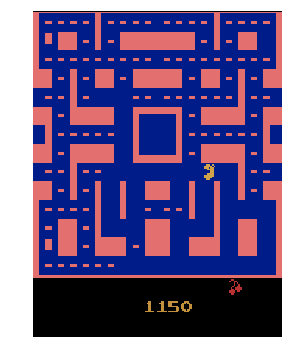

In [6]:
untrained_agent = Agent(state_size=states_stack_depth, action_size=action_space, seed=10)

fig, ax = plt.subplots(figsize=(8, 6))

# watch an untrained agent
stackenv = StackEnv(gym.make('MsPacman-v0'), skipframe=2)
state_inputs = stackenv.reset()

img = ax.imshow(stackenv.env.render(mode='rgb_array'))
for j in range(1000):
    #action = untrained_agent.act(state_inputs)
    action = np.random.choice(action_space)
    img.set_data(stackenv.env.render(mode='rgb_array')) 
    plt.axis('off')
    display.display(plt.gcf())
    display.clear_output(wait=True)

    next_state_inputs, reward, done = stackenv.step(action)
    state_inputs = next_state_inputs
    
    if done:
        break 
        
stackenv.close()

In [7]:
def loadTrainedModel(agent, path):
    state_dicts = torch.load(path)
    print(state_dicts['model'].keys())

    agent.qnetwork_local.load_state_dict(state_dicts['model'])
    agent.optimizer.load_state_dict(state_dicts['optimizer'])
    
    return agent, state_dicts['eps'], state_dicts['n_episodes'], state_dicts['i_episode']

In [8]:
def saveTrainedModel(agent, path, eps, n_episodes, i_episode):
    state_dicts = {'model': agent.qnetwork_local.state_dict(), 
                   'optimizer': agent.optimizer.state_dict(),
                   'eps': eps, 
                   'n_episodes': n_episodes,
                   'i_episode': i_episode
                  }
    torch.save(state_dicts, path)

In [ ]:
model_dir = 'saved_models/'
model_name = 'MsPacman-v1-3D-all-dicts-local.pt'

agent = Agent(state_size=states_stack_depth, action_size=action_space, seed=0)
print(agent.qnetwork_local)

loadSavedModel = True

if loadSavedModel == True:
    agent, eps, n_episodes, i_episode = loadTrainedModel(agent, model_dir+model_name)
    eps = 1.0
    n_episodes = 5000
    i_episode = 1
else:
    eps = 1.0
    n_episodes = 10000
    i_episode = 1

current device: cuda:0
use duel network (a and v): True
use double network: True
use reward scaling: False
use error clipping: True
buffer size: 100000
batch size: 64
learning rate: 0.0002
min replay size: 100000
target network update: 1000
optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.0002
    weight_decay: 0
)
QNetwork(
  (conv1): Conv2d(4, 32, kernel_size=(8, 8), stride=(4, 4))
  (conv2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2))
  (conv3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (fc1a): Linear(in_features=3136, out_features=512, bias=True)
  (fc3a): Linear(in_features=512, out_features=9, bias=True)
  (fc1v): Linear(in_features=3136, out_features=512, bias=True)
  (fc3v): Linear(in_features=512, out_features=1, bias=True)
)
odict_keys(['conv1.weight', 'conv1.bias', 'conv2.weight', 'conv2.bias', 'conv3.weight', 'conv3.bias', 'fc1a.weight', 'fc1a.bias', 'fc3a.weight', 'fc3a.bias', 'fc1v.weight', 'fc1v.bias'

In [ ]:
def dqn_3D(n_episodes=1000, i_episode=1, max_t=1000, eps_start=1.0, eps_end=0.05, eps_decay=0.9995):
    """Deep Q-Learning.
    
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
    """
    stackenv = StackEnv(gym.make('MsPacman-v0'))
    
    scores = []                        # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores
    frame_counter = 0                  # keep track of number of frames seen
    
    eps = eps_start                    # initialize epsilon 
    eps_decay=1-1/(n_episodes+1000)    # make sure decay come to min 
    
    while i_episode < n_episodes + 1:
        
        state_inputs = stackenv.reset()    
        score = 0

        for t in range(max_t):

            action = agent.act(state_inputs, eps) #for action recommendation
            
            next_state_inputs, reward, done = stackenv.step(action)
            
            frame_counter += 1
            
            agent.step(state_inputs , action, reward, next_state_inputs, done, (i_episode,n_episodes))
            
            state_inputs = next_state_inputs
            
            score += reward
            
            if done:
                break 
                
        if agent.isTraining == True:     #learning starts   
            scores_window.append(score)       # save most recent score
            scores.append(score)              # save most recent score

            eps = max(eps_end, eps_decay*eps) # decay epsilon

            print('\rEpisode: {}\tAvg Score: {:.2f}\tb: {:.3f}'.format(i_episode, 
                                                                       np.mean(scores_window),
                                                                       agent.p_replay_beta
                                                                      ), end="")

            if i_episode % 100 == 0:
                latest_lr = agent.optimizer.state_dict()['param_groups'][0]['lr']

                print(('\rEpisode: {}\tAvg Score: {:.2f}\tsteps: {}\teps: {:.2f}'
                       '\tlr: {:1.2e}\tp: {:.3f}  b: {:.3f}').format(i_episode, np.mean(scores_window),
                                                                     agent.t_step, eps, latest_lr, 
                                                                     agent.p_replay_alpha, 
                                                                     agent.p_replay_beta, end="")) 

                saveTrainedModel(agent, model_dir+model_name, eps, n_episodes, i_episode)

            if np.mean(scores_window)>=2500.0:
                print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100,
                                                                                             np.mean(scores_window)))

                saveTrainedModel(agent, model_dir+model_name, eps, n_episodes, i_episode)
                break
            
            i_episode += 1
        else:
            print('\rTraining to be started... Steps: {} '.format(agent.t_step), end="")

    stackenv.close()
        
    return scores

scores = dqn_3D(n_episodes, i_episode=i_episode, eps_start=eps)

Training to be started... Steps: 99896 training starts!                            
Episode: 100	Avg Score: 373.10	steps: 116225	eps: 0.98	lr: 2.00e-04	p: 0.700  b: 0.510
Episode: 200	Avg Score: 422.40	steps: 133481	eps: 0.97	lr: 2.00e-04	p: 0.700  b: 0.520
Episode: 300	Avg Score: 418.30	steps: 150908	eps: 0.95	lr: 2.00e-04	p: 0.700  b: 0.530
Episode: 400	Avg Score: 430.60	steps: 168125	eps: 0.94	lr: 2.00e-04	p: 0.700  b: 0.540
Episode: 500	Avg Score: 420.80	steps: 184976	eps: 0.92	lr: 2.00e-04	p: 0.700  b: 0.550
Episode: 600	Avg Score: 449.40	steps: 202450	eps: 0.90	lr: 2.00e-04	p: 0.700  b: 0.560
Episode: 700	Avg Score: 436.20	steps: 219404	eps: 0.89	lr: 2.00e-04	p: 0.700  b: 0.570
Episode: 800	Avg Score: 415.30	steps: 236156	eps: 0.88	lr: 2.00e-04	p: 0.700  b: 0.580
Episode: 900	Avg Score: 499.50	steps: 254737	eps: 0.86	lr: 2.00e-04	p: 0.700  b: 0.590
Episode: 1000	Avg Score: 487.00	steps: 272445	eps: 0.85	lr: 2.00e-04	p: 0.700  b: 0.600
Episode: 1100	Avg Score: 484.10	steps: 290089

In [ ]:
# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

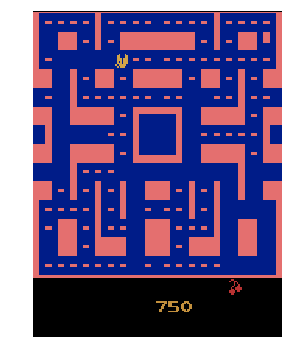

In [12]:
# load the weights from file
#torch.load(agent.qnetwork_local.state_dict(), model_dir+model_name)
fig, ax = plt.subplots(figsize=(8, 6))

stackenv = StackEnv(gym.make('MsPacman-v0'), skipframe=4)

agent.qnetwork_local.eval()
agent.qnetwork_target.eval()

for i in range(3):
    # watch an untrained agent
    state_inputs = stackenv.reset()  
    
    img = ax.imshow(stackenv.env.render(mode='rgb_array'))
    for j in range(1000):
        action = agent.act(state_inputs)
        img.set_data(stackenv.env.render(mode='rgb_array')) 
        plt.axis('off')
        display.display(plt.gcf())
        display.clear_output(wait=True)
        next_state_inputs, reward, done = stackenv.step(action)
        
        state_inputs = next_state_inputs
        
        if done:
            break 

agent.qnetwork_local.train()
#agent.qnetwork_target.train()
            
stackenv.env.close()